In [ ]:
#!pip install -qU python-gdcm pydicom pylibjpeg

In [ ]:
#!pip install ../input/nnunet-wheels/MedPy-0.4.0-py3-none-any.whl  

In [ ]:
#DEBUG = True

In [1]:
import os
import cv2
import itertools
import glob
#import gdcm
import pydicom
import logging
logging.getLogger('tensorflow').disabled = True

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow import keras
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint


from pydicom.data import get_testdata_file
from PIL import Image
from pandas.plotting import scatter_matrix
sns.set_style('darkgrid')
sns.set_color_codes('bright')
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm
from joblib import Parallel, delayed

In [ ]:
#train_df["patient_id"].nunique()

In [ ]:
#test.shape

In [ ]:
#len(test)

# visulaze the data

In [2]:
base_img_dir = "/kaggle/input/rsna-breast-cancer-detection/train_images"
train_df = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/train.csv")
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [3]:
total_images = len(train_df)
print(f"There are {total_images} images in all")
patient_num = len(train_df["patient_id"].unique())
print(f"There are {patient_num} patients in all.")

There are 54706 images in all
There are 11913 patients in all.


Text(0.5, 0, 'Number')

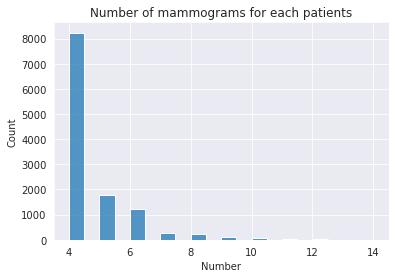

In [4]:
patient_image = train_df.groupby("patient_id").image_id.count()
sns.histplot(patient_image.values, bins=20)
plt.title("Number of mammograms for each patients")
plt.xlabel("Number")

<AxesSubplot:xlabel='cancer', ylabel='age'>

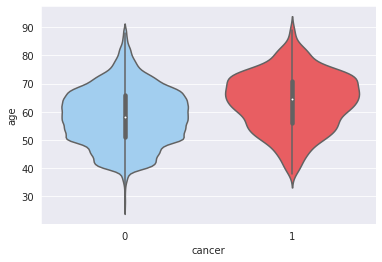

In [5]:
colors = ["light blue", "light red"]
sns.violinplot(x="cancer", y="age", data=train_df, palette=sns.xkcd_palette(colors))

# Loading images and preprocess it

In [6]:
def get_image_label(img_path, df):
    X = []
    y = []
    for file in tqdm(os.listdir(img_path)):
        if file.endswith('.png'):
            im = cv2.imread(os.path.join(img_path, file), 0)
            im = cv2.resize(im, (128, 128))  # reduce to 128 x 128 
            im = im.reshape((128, 128, 1))
            #im = im / 225.0
            X.append(im)
            fname = file.split('.')[0]
            p_id, im_id = fname.split("_")
            p_id = int(p_id)
            im_id = int(im_id)
            data = df.loc[(df["patient_id"]==p_id) & (df["image_id"]==im_id)]
            label = data["cancer"].values[0]
            y.append(label)
            # save memory
            del im
    return X, y

            
img_path = "/kaggle/input/rsna-breast-cancer-256-pngs"
X, y = get_image_label(img_path, train_df)
X_ = np.array(X)
y_ = np.array(y)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.2, stratify=y_)

  0%|          | 0/54706 [00:00<?, ?it/s]

In [ ]:
#X_train.shape

In [ ]:
#X_ .shape

# Training

In [7]:
EPOCHS = 10
BATCH_SIZE = 32

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping



# Define the CNN model
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model with appropriate loss, optimizer, and metric
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the callbacks
checkpoint_path = "model_checkpoint.h5"
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_accuracy', 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='max', 
                             verbose=1)


early_stop = EarlyStopping(
    monitor = 'val_loss',
    mode = 'auto',
    min_delta = 0,
    patience = 2,
    verbose = 0, 
    restore_best_weights = True)


    # Train the model with training and validation data
history = model.fit(X_train,
                    y_train, 
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_data=(X_val,y_val), 
                    callbacks=[checkpoint, early_stop])

# Load the saved checkpoint
model.load_weights(checkpoint_path)

# Evaluate the model on test data
#test_loss, test_accuracy = model.evaluate(test)

Epoch 1/10
1368/1368 [==============================] - 32s 17ms/step - loss: 0.1640 - accuracy: 0.9786 - val_loss: 0.1113 - val_accuracy: 0.9788

Epoch 00001: val_accuracy improved from -inf to 0.97880, saving model to model_checkpoint.h5
Epoch 2/10
1368/1368 [==============================] - 22s 16ms/step - loss: 0.1111 - accuracy: 0.9788 - val_loss: 0.1032 - val_accuracy: 0.9788

Epoch 00002: val_accuracy did not improve from 0.97880
Epoch 3/10
1368/1368 [==============================] - 22s 16ms/step - loss: 0.1028 - accuracy: 0.9788 - val_loss: 0.1031 - val_accuracy: 0.9788

Epoch 00003: val_accuracy did not improve from 0.97880
Epoch 4/10
1368/1368 [==============================] - 22s 16ms/step - loss: 0.1018 - accuracy: 0.9788 - val_loss: 0.1037 - val_accuracy: 0.9788

Epoch 00004: val_accuracy did not improve from 0.97880
Epoch 5/10
1368/1368 [==============================] - 22s 16ms/step - loss: 0.1000 - accuracy: 0.9788 - val_loss: 0.1087 - val_accuracy: 0.9788

Epoch 0

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

# Testing

print('////////////////////////////////// Testing Part /////////////////////////////////////')
print('////////////////////////////////////////////////////////////////////////////////////')
test_loss, test_accuracy = model.evaluate(X_val, y_val)
print('Test loss: {0:.4f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

from medpy.io import load
from skimage.transform import resize

test_path = "/kaggle/input/rsna-breast-cancer-detection/test.csv"
test_img_dir = "/kaggle/input/rsna-breast-cancer-detection/test_images"
test_df = pd.read_csv(test_path)
test = []
target_size = (128, 128, 1)


for i in range(len(test_df)):
    line = test_df.iloc[i]
    p_id = str(line["patient_id"])
    im_id = str(line["image_id"]) + '.dcm'
    #prediction_id.append(line["prediction_id"])
    path = os.path.join(test_img_dir, p_id, im_id)
        #im = pydicom.dcmread(path).pixel_array
        #im = np.array(im)
        #im = cv2.resize(im, (128, 128))
        #im = im.reshape((128,128,1))
    data, header = load(path)
    resized_data = resize(data, target_size, anti_aliasing=True)
    test.append(resized_data)
    
test = np.array(test)

In [10]:
output_dir ="/kaggle/working/hiddentests"
os.makedirs(output_dir, exist_ok=True)

In [11]:
import SimpleITK as sitk
import numpy as np
from skimage import filters
import matplotlib.pyplot as plt

subtest_path = "/kaggle/input/rsna-breast-cancer-detection/test.csv"
subtest_img_dir = "/kaggle/input/rsna-breast-cancer-detection/test_images"



test_df = pd.read_csv(subtest_path)
prediction_id = []
hiddin_test = []
cancer = []
for i in range(len(test_df)):
    line = test_df.iloc[i]
    p_id = str(line["patient_id"])
    im_id = str(line["image_id"]) + '.dcm'
    #prediction_id.append(line["prediction_id"])
    path = os.path.join(subtest_img_dir, p_id, im_id)

    # Load DICOM image using SimpleITK
    image = sitk.ReadImage(path)

    # Get the original image size
    original_size = image.GetSize()

    # Calculate the size of the resized image
    new_size = [128, 128, original_size[2]]

    # Resize image
    resized_image = sitk.Resample(image, original_size, sitk.Transform(), sitk.sitkLinear, image.GetOrigin(), image.GetSpacing(), image.GetDirection(), 0.0, image.GetPixelIDValue())

    # Convert resized image from SimpleITK object to numpy array
    np_image = sitk.GetArrayFromImage(resized_image)

    # Normalize image intensity values
    np_image = (np_image - np.min(np_image)) / (np.max(np_image) - np.min(np_image))

    # Remove noise from image
    np_image = filters.median(np_image)

    # Convert numpy array to image
    img = Image.fromarray((np_image[np_image.shape[0]//2] * 255).astype(np.uint8))
    
    output_path = os.path.join(output_dir, im_id[:-4] +  ".png")
    #im.save(output_path)
    # Save image as PNG
    img.save(output_path)

In [ ]:
#test.shape

y = model.predict(test)
y

In [ ]:
#model.predict(test)[0]

In [ ]:
#y[0][0]

# Submission


test_path = "/kaggle/input/rsna-breast-cancer-detection/test.csv"
test_img_dir = "/kaggle/input/rsna-breast-cancer-detection/test_images"
test_df = pd.read_csv(test_path)
prediction_id = []
for i in range(len(test_df)):
    line = test_df.iloc[i]
    p_id = str(line["patient_id"])
    im_id = str(line["image_id"]) + '.dcm'
    prediction_id.append(line["prediction_id"])
        

cancer = []
for i in range(len(test_df)):
    prob = model.predict(test)[i][0]
    cancer.append(prob)

cancer

prediction_id

submission = pd.DataFrame(data={"prediction_id": prediction_id, "cancer": cancer})
submission = submission.sort_values("cancer", ascending=False)

prediction = []
for img in tests :
    prediction.append(model.predict(img))

submission = submission.drop_duplicates(subset="prediction_id", keep="first")
submission.to_csv("submission.csv", index=False)
submission